<a id="importing"></a>
## Importing libs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm # quantification and model calibration
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 
np.random.seed(seed)

plt.style.use('seaborn-talk') 

THEANO_FLAGS='optimizer=fast_compile' 

<a id="loading"></a>
## Loading data

In [8]:
df_covid = pd.read_csv("sample_data/covid_19_clean_complete.csv", parse_dates=['Date'])

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  14664 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [9]:
df_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [10]:
columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths"]
df_covid_cases = df_covid[columns_to_filter_cases]

df_covid_cases.head()

,Country/Region,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Albania,2020-01-22,0,0
2,Algeria,2020-01-22,0,0
3,Andorra,2020-01-22,0,0
4,Angola,2020-01-22,0,0


<a id="cleaning"></a>
## Data cleaning



In [11]:
print(f"First day entry:\t {df_covid['Date'].min()}")
print(f"Last day reported:\t {df_covid['Date'].max()}")
print(f"Total of tracked days:\t {df_covid['Date'].max() - df_covid['Date'].min()}")

First day entry:	 2020-01-22 00:00:00
Last day reported:	 2020-07-27 00:00:00
Total of tracked days:	 187 days 00:00:00


In [12]:
df_covid.rename(
    columns={
        'Date': 'date', 
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'}, 
    inplace=True
)

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


Active Case = confirmed - deaths - recovered

In [14]:
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,Active,WHO Region,active
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa,0
...,...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa,117
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean,375
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa,19
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe,1147


<a id="eda"></a>
## (Very) Basic EDA

In [15]:
df_grouped = df_covid.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()

df_grouped

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,date,confirmed,deaths
0,2020-01-22,555,17
1,2020-01-23,654,18
2,2020-01-24,941,26
3,2020-01-25,1434,42
4,2020-01-26,2118,56
...,...,...,...
183,2020-07-23,15510481,633506
184,2020-07-24,15791645,639650
185,2020-07-25,16047190,644517
186,2020-07-26,16251796,648621


In [16]:
confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60, color='blue').encode(
    x=alt.X('date', axis=alt.Axis(title='Date')),
    y=alt.Y('confirmed', axis=alt.Axis(title='Cases'))
)

deaths_plot = alt.Chart(df_grouped).mark_circle(size=60, color='red').encode(
    x='date',
    y='deaths'
)

worldwide_plot = confirmed_plot + deaths_plot
worldwide_plot.interactive()

alt.LayerChart(...)

In [17]:
def get_df_country_cases(df: pd.DataFrame, country_name: str) -> pd.DataFrame:
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date

In [18]:
def altair_plot_for_confirmed_and_deaths(df_grouped: pd.DataFrame, data_at_x_axis: str='date') -> alt.Chart:
    confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=alt.X(data_at_x_axis, axis=alt.Axis(title='Date')),
        y=alt.Y('confirmed', axis=alt.Axis(title='Cases'), title='Confirmed'),
        color=alt.Color("confirmed_marker", title="Cases"),
    )

    deaths_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=data_at_x_axis,
        y='deaths',
        color=alt.Color("deaths_marker"),
    )

    return confirmed_plot + deaths_plot

Italy:

In [19]:
df_grouped_italy = get_df_country_cases(df_covid, "Italy")

df_grouped_italy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,date,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,0,0,Confirmed,Deaths
1,2020-01-23,0,0,Confirmed,Deaths
2,2020-01-24,0,0,Confirmed,Deaths
3,2020-01-25,0,0,Confirmed,Deaths
4,2020-01-26,0,0,Confirmed,Deaths
...,...,...,...,...,...
183,2020-07-23,245338,35092,Confirmed,Deaths
184,2020-07-24,245590,35097,Confirmed,Deaths
185,2020-07-25,245864,35102,Confirmed,Deaths
186,2020-07-26,246118,35107,Confirmed,Deaths


In [20]:
altair_plot_for_confirmed_and_deaths(df_grouped_italy).interactive()

alt.LayerChart(...)

In [21]:
df_italy_cases_by_day = df_grouped_italy[df_grouped_italy.confirmed > 0]
df_italy_cases_by_day = df_italy_cases_by_day.reset_index(drop=True)
df_italy_cases_by_day['day'] = df_italy_cases_by_day.date.apply(lambda x: (x - df_italy_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_italy_cases_by_day = df_italy_cases_by_day[reordered_columns]

df_italy_cases_by_day

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-31,0,2,0,Confirmed,Deaths
1,2020-02-01,1,2,0,Confirmed,Deaths
2,2020-02-02,2,2,0,Confirmed,Deaths
3,2020-02-03,3,2,0,Confirmed,Deaths
4,2020-02-04,4,2,0,Confirmed,Deaths
...,...,...,...,...,...,...
174,2020-07-23,174,245338,35092,Confirmed,Deaths
175,2020-07-24,175,245590,35097,Confirmed,Deaths
176,2020-07-25,176,245864,35102,Confirmed,Deaths
177,2020-07-26,177,246118,35107,Confirmed,Deaths


<a id="models"></a>
## Epidemiology models
#### Modified SEIR model with deaths (SEIRD)


\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I - \delta I \\
    \dot{R} &= \zeta I \\
    \dot{D} &= \delta I
\end{align*}

#### Modified SEIRD model considering quarantine lockdown (SEIRD-Q)


\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E - \omega S\\
    \dot{E} &= \beta S I - \alpha E + \gamma S E - \omega E \\
    \dot{I} &= \alpha E - \zeta I - \delta I - \omega I \\
    \dot{R} &= \zeta I + \omega (S + E + I) \\
    \dot{D} &= \delta I
\end{align*}




<a id="implementations"></a>
## Test

In [22]:
@jit(nopython=True)
def sir_model(t, X, beta=1, zeta=1/15):
    S, I, R = X
    S_prime = - beta * S * I
    I_prime = beta * S * I - zeta * I
    R_prime = zeta * I
    return S_prime, I_prime, R_prime


@jit(nopython=True)
def sird_model(t, X, beta=1, delta=0.02, zeta=1/15):
    """
    SIR model that takes into account the number of deaths.
    """
    S, I, R, D = X
    S_prime = - beta * S * I
    I_prime = beta * S * I - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, I_prime, R_prime, D_prime


@jit(nopython=True)
def seir2_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    This is a modified SEIR model in order to take into account incubation time in exposed individual.
    The exposed individuals can transmit the infection to susceptible individuals.
    """
    S, E, I, R = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    return S_prime, E_prime, I_prime, R_prime


@jit(nopython=True)
def seird_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    A modified SEIR model in order to take into account deaths.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime


@jit(nopython=True)
def seirdq_model(t, X, alpha=1/5, beta=1, gamma=0, omega=0, zeta=1/15, delta=0.02):
    """
    A modified SEIRD model in order to take into account quarantine.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S - omega * S
    E_prime = beta * S * I - alpha * E + gamma * E * S - omega * E
    I_prime = alpha * E - zeta * I - delta * I - omega * I
    R_prime = zeta * I + omega * (S + E + I)
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime

ODE solvers wrappers menggunakan `scipy.integrate.solve_ivp`:

In [23]:
def sir_ode_solver(y0, t_span, t_eval, beta=1, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sir_model(t, y, beta=beta, zeta=zeta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def sird_ode_solver(y0, t_span, t_eval, beta=1, delta=0.02, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sird_model(t, y, beta=beta, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seir_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, alpha=1/4, zeta=1/14, delta=0.0):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seir2_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seird_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seirdq_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, omega=0, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seirdq_model(t, y, alpha=alpha, beta=beta, gamma=gamma, omega=omega, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

Mencari populasi

In [26]:
df_population = pd.read_csv("sample_data/countries of the world.csv")

df_population

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [27]:
italy_population = float(df_population[df_population.Country == 'Italy '].Population)

target_population = italy_population
target_population

58133509.0

In [28]:
df_target_country = df_italy_cases_by_day
S0, E0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.

y0_sir = S0 / target_population, I0 / target_population, R0  # SIR IC array
y0_sird = S0 / target_population, I0 / target_population, R0, D0  # SIRD IC array
y0_seir = S0 / target_population, E0 / target_population, I0 / target_population, R0  # SEIR IC array
y0_seird = S0 / target_population, E0 / target_population, I0 / target_population, R0, D0  # SEIRD IC array

memilih model

In [29]:
has_to_run_sir = True
has_to_run_sird = True
has_to_run_seir = True
has_to_run_seird = True
has_to_run_seirdq = True

<a id="least-squares"></a>
## Least-Squares fitting



In [30]:
def sir_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi, _ = simulated_ode_solution
    
    residual = f_exp - simulated_qoi

    return np.sum(residual ** 2.0)


def sird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def seir_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi, _ = simulated_ode_solution
    
    residual = f_exp - simulated_qoi

    return np.sum(residual ** 2.0)


def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def callback_de(xk, convergence):
    print(f'parameters = {xk}')

Setting fitting domain dan observasi :

In [31]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values / target_population
dead_individuals = df_target_country.deaths.values / target_population

In [32]:
if has_to_run_sir:
    num_of_parameters_to_fit_sir = 1
    bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]

    result_sir = optimize.differential_evolution(
        sir_least_squares_error_ode, 
        bounds=bounds_sir, 
        args=(data_time, infected_individuals, sir_ode_solver, y0_sir), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.5,
#         mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_sir)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00119491
parameters = [0.13833408]
differential_evolution step 2: f(x)= 0.00119491
parameters = [0.13833408]
differential_evolution step 3: f(x)= 0.00118741
parameters = [0.13872787]
differential_evolution step 4: f(x)= 0.00118515
parameters = [0.139731]
differential_evolution step 5: f(x)= 0.00118317
parameters = [0.13952104]
differential_evolution step 6: f(x)= 0.00118278
parameters = [0.13943355]
differential_evolution step 7: f(x)= 0.00118278
parameters = [0.13943355]
differential_evolution step 8: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 9: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 10: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 11: f(x)= 0.00118262
parameters = [0.13933343]
differential_evolution step 12: f(x)= 0.00118262
parameters = [0.13932942]
     fun: 0.0011826205577735352
     jac: array([-1.25377139e-07])
 message: 'Optimization terminated successfu

In [33]:
if has_to_run_sird:
    # num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_sird = [(0, 1), (0, 0.2)]

    result_sird = optimize.differential_evolution(
        sird_least_squares_error_ode, 
        bounds=bounds_sird, 
        args=(data_time, [infected_individuals, dead_individuals], sird_ode_solver, y0_sird), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.5,
    #     mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_sird)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00122251
parameters = [0.13900478 0.00040152]
differential_evolution step 2: f(x)= 0.00122251
parameters = [0.13900478 0.00040152]
differential_evolution step 3: f(x)= 0.00121
parameters = [0.14550092 0.00663785]
differential_evolution step 4: f(x)= 0.00121
parameters = [0.14550092 0.00663785]
differential_evolution step 5: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 6: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 7: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 8: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 9: f(x)= 0.00120554
parameters = [0.14868372 0.00917725]
differential_evolution step 10: f(x)= 0.00120554
parameters = [0.14868372 0.00917725]
differential_evolution step 11: f(x)= 0.00120511
parameters = [0.14995686 0.01064406]
differential_evolution step 12: f(x)= 0.00120511
parameters = [0.1499

In [34]:
if has_to_run_seird:
    num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_seird = [(0, 1), (0, 1), (0, 0.2)]

    result_seird = optimize.differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
    #     mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seird)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00123081
parameters = [0.0833807  0.15222429 0.00685609]
differential_evolution step 2: f(x)= 0.00117361
parameters = [0.13286456 0.09246975 0.01789635]
differential_evolution step 3: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 4: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 5: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 6: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 7: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 8: f(x)= 0.00109602
parameters = [0.03261455 0.24581994 0.00777842]
differential_evolution step 9: f(x)= 0.00109602
parameters = [0.03261455 0.24581994 0.00777842]
differential_evolution step 10: f(x)= 0.00109152
parameters = [0.01047705 0.28699461 0.01124698]
differential_evolution step 11: f(x)= 0

In [35]:
if has_to_run_seirdq:
#     num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_seird = [(0, 1), (0, 1), (0, 0.2), (0, 1)]

    result_seirdq = optimize.differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seirdq_ode_solver, y0_seird), 
        popsize=200,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
    #     mutation=0.7,
        maxiter=200,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seirdq)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00157355
parameters = [0.80627216 0.29716976 0.0158321  0.03357078]
differential_evolution step 2: f(x)= 0.00157355
parameters = [0.80627216 0.29716976 0.0158321  0.03357078]
     fun: 0.0001696157321614781
     jac: array([-3.73597822e-04, -3.02589675e-04,  4.60679753e-05,  7.35387515e-03])
 message: 'Optimization terminated successfully.'
    nfev: 2865
     nit: 2
 success: True
       x: array([0.12534752, 0.33575254, 0.00203875, 0.00787156])


In [36]:
if has_to_run_seir:
    num_of_parameters_to_fit_seir = 2
    bounds_seir = num_of_parameters_to_fit_seir * [(0, 1)]

    result_seir = optimize.differential_evolution(
        seir_least_squares_error_ode, 
        bounds=bounds_seir, 
        args=(data_time, infected_individuals, seir_ode_solver, y0_seir), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
#         mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seir)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00109059
parameters = [0.04468449 0.21955221]
differential_evolution step 2: f(x)= 0.00109059
parameters = [0.04468449 0.21955221]
differential_evolution step 3: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 4: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 5: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 6: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 7: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 8: f(x)= 0.00106832
parameters = [0.03860465 0.22924511]
differential_evolution step 9: f(x)= 0.00106472
parameters = [0.01924294 0.26714062]
differential_evolution step 10: f(x)= 0.00106472
parameters = [0.01924294 0.26714062]
differential_evolution step 11: f(x)= 0.00106472
parameters = [0.01924294 0.26714062]
differential_evolution step 12: f(x)= 0.00106472
parameters = [

In [37]:
zeta_fitted = 1/14  # recover rate... the inverse is equal to the amount of days needed to recover from the disease
if has_to_run_sir:
    beta_fitted_sir = result_sir.x  # SIR parameters
    
if has_to_run_sird:
    beta_fitted_sird, delta_fitted_sird = result_sird.x  # SIRD parameters
    
alpha_fitted = 1/4
if has_to_run_seird:
    beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird = result_seird.x  # SEIRD parameters
    
if has_to_run_seirdq:
    beta_fitted_seirdq, gamma_fitted_seirdq, delta_fitted_seirdq, omega_fitted_seirdq = result_seirdq.x  # SEIRD parameters

if has_to_run_seir:
#     beta_fitted_seir, gamma_fitted_seir = result_seir.x  # SEIR parameters
#     gamma_fitted_seir = 0.0
    beta_fitted_seir, gamma_fitted_seir = result_seir.x  # SEIR parameters

In [38]:
t0 = data_time.min()
tf = data_time.max()

if has_to_run_sir:
    solution_ODE_sir = sir_ode_solver(y0_sir, (t0, tf), data_time, beta_fitted_sir, zeta_fitted)  # SIR
    t_computed_sir, y_computed_sir = solution_ODE_sir.t, solution_ODE_sir.y
    S_sir, I_sir, R_sir = y_computed_sir

if has_to_run_sird:
    solution_ODE_sird = sird_ode_solver(y0_sird, (t0, tf), data_time, beta_fitted_sird, delta_fitted_sird, zeta_fitted)  # SIRD
    t_computed_sird, y_computed_sird = solution_ODE_sird.t, solution_ODE_sird.y
    S_sird, I_sird, R_sird, D_sird = y_computed_sird

if has_to_run_seird:
    solution_ODE_seird = seird_ode_solver(y0_seird, (t0, tf), data_time, beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird, alpha_fitted, zeta_fitted)  # SEIRD
    t_computed_seird, y_computed_seird = solution_ODE_seird.t, solution_ODE_seird.y
    S_seird, E_seird, I_seird, R_seird, D_seird = y_computed_seird

if has_to_run_seirdq:
    solution_ODE_seirdq = seirdq_ode_solver(
        y0_seird, 
        (t0, tf), 
        data_time, 
        beta_fitted_seirdq, 
        gamma_fitted_seirdq, 
        delta_fitted_seirdq, 
        omega_fitted_seirdq, 
        alpha_fitted, 
        zeta_fitted
    )
    t_computed_seirdq, y_computed_seirdq = solution_ODE_seirdq.t, solution_ODE_seirdq.y
    S_seirdq, E_seirdq, I_seirdq, R_seirdq, D_seirdq = y_computed_seirdq
    
if has_to_run_seir:
    solution_ODE_seir = seir_ode_solver(y0_seir, (t0, tf), data_time, beta_fitted_seir, gamma_fitted_seir, alpha_fitted,  zeta_fitted)  # SEIR
    t_computed_seir, y_computed_seir = solution_ODE_seir.t, solution_ODE_seir.y
    S_seir, E_seir, I_seir, R_seir = y_computed_seir

In [39]:
model_list = list()
alpha_list = list()
beta_list = list()
delta_list = list()
gamma_list = list()
omega_list = list()
zeta_list = list()

if has_to_run_sir:
    model_list.append("SIR")
    alpha_list.append("-")
    beta_list.append(np.float(beta_fitted_sir))
    delta_list.append("-")
    gamma_list.append("-")
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_sird:
    model_list.append("SIRD")
    alpha_list.append("-")
    beta_list.append(beta_fitted_sird)
    delta_list.append(delta_fitted_sird)
    gamma_list.append("-")
    omega_list.append("-")
    zeta_list.append(zeta_fitted)
    
if has_to_run_seir:
    model_list.append("SEIR")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seir)
    delta_list.append("-")
    gamma_list.append(gamma_fitted_seir)
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_seird:
    model_list.append("SEIRD")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seird)
    delta_list.append(delta_fitted_seird)
    gamma_list.append(gamma_fitted_seird)
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_seirdq:
    model_list.append("SEIRD-Q")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seirdq)
    delta_list.append(delta_fitted_seirdq)
    gamma_list.append(gamma_fitted_seirdq)
    omega_list.append(omega_fitted_seirdq)
    zeta_list.append(zeta_fitted)
    
parameters_dict = {
    "Model": model_list,
    r"$\alpha$": alpha_list,
    r"$\beta$": beta_list,
    r"$\delta$": delta_list,
    r"$\gamma$": gamma_list,
    r"$\omega$": omega_list,
    r"$\zeta$": zeta_list,
}

df_parameters_calibrated = pd.DataFrame(parameters_dict)

df_parameters_calibrated

,Model,$\alpha$,$\beta$,$\delta$,$\gamma$,$\omega$,$\zeta$
0,SIR,-,0.139331,-,-,-,0.071429
1,SIRD,-,0.149700,0.01035,-,-,0.071429
2,SEIR,0.25,0.018555,-,0.268765,-,0.071429
3,SEIRD,0.25,0.015197,0.00841822,0.277354,-,0.071429
4,SEIRD-Q,0.25,0.125348,0.00203875,0.335753,0.00787156,0.071429


In [40]:
print(df_parameters_calibrated.to_latex(index=False))

\begin{tabular}{llrlllr}
\toprule
   Model & \$\textbackslash alpha\$ &   \$\textbackslash beta\$ &    \$\textbackslash delta\$ &  \$\textbackslash gamma\$ &    \$\textbackslash omega\$ &   \$\textbackslash zeta\$ \\
\midrule
     SIR &        - &  0.139331 &           - &         - &           - &  0.071429 \\
    SIRD &        - &  0.149700 &     0.01035 &         - &           - &  0.071429 \\
    SEIR &     0.25 &  0.018555 &           - &  0.268765 &           - &  0.071429 \\
   SEIRD &     0.25 &  0.015197 &  0.00841822 &  0.277354 &           - &  0.071429 \\
 SEIRD-Q &     0.25 &  0.125348 &  0.00203875 &  0.335753 &  0.00787156 &  0.071429 \\
\bottomrule
\end{tabular}



hasil kalibrasi 

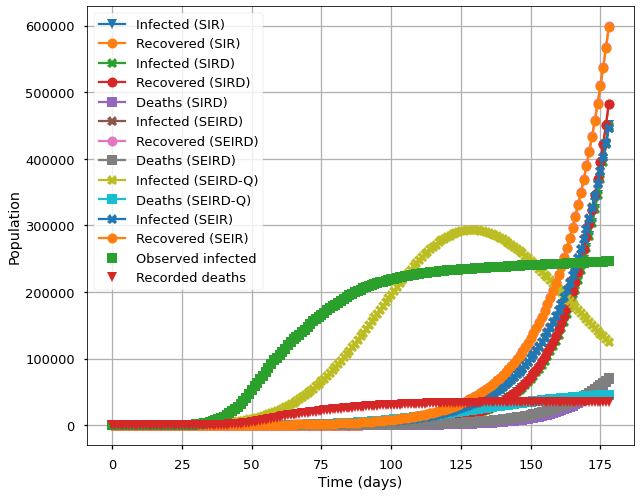

In [41]:
plt.figure(figsize=(9,7))

if has_to_run_sir:
    plt.plot(t_computed_sir, I_sir * target_population, label='Infected (SIR)', marker='v', linestyle="-", markersize=10)
    plt.plot(t_computed_sir, R_sir * target_population, label='Recovered (SIR)', marker='o', linestyle="-", markersize=10)
    
if has_to_run_sird:
    plt.plot(t_computed_sird, I_sird * target_population, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, R_sird * target_population, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, D_sird * target_population, label='Deaths (SIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seirdq:
    plt.plot(t_computed_seirdq, I_seirdq * target_population, label='Infected (SEIRD-Q)', marker='X', linestyle="-", markersize=10)
#     plt.plot(t_computed_seirdq, R_seirdq * target_population, label='Recovered (SEIRD-Q)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seirdq, D_seirdq * target_population, label='Deaths (SEIRD-Q)', marker='s', linestyle="-", markersize=10)

if has_to_run_seir:
    plt.plot(t_computed_seir, I_seir * target_population, label='Infected (SEIR)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seir, R_seir * target_population, label='Recovered (SEIR)', marker='o', linestyle="-", markersize=10)
    
plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()
plt.savefig("all_deterministic_calibration.png")
plt.show()

In [42]:
methods_list = list()
deaths_list = list()
if has_to_run_sird:
    methods_list.append("SIRD")
    deaths_list.append(int(D_sird.max() * target_population))
    print(f"Death estimate for today (SIRD):\t{int(D_sird.max() * target_population)}")
    
if has_to_run_seird:
    methods_list.append("SEIRD")
    deaths_list.append(int(D_seird.max() * target_population))
    print(f"Death estimate for today (SEIRD):\t{int(D_seird.max() * target_population)}")
    
if has_to_run_seirdq:
    methods_list.append("SEIRD-Q")
    deaths_list.append(int(D_seirdq.max() * target_population))
    print(f"Death estimate for today (SEIRD-Q):\t{int(D_seirdq.max() * target_population)}")

methods_list.append("Recorded")
deaths_list.append(int(dead_individuals[-1] * target_population))

death_estimates_dict = {"Method": methods_list, "Deaths estimate": deaths_list}
df_deaths_estimates = pd.DataFrame(death_estimates_dict)
print(f"Recorded deaths until today:\t{int(dead_individuals[-1] * target_population)}")

Death estimate for today (SIRD):	69932
Death estimate for today (SEIRD):	70598
Death estimate for today (SEIRD-Q):	46041
Recorded deaths until today:	35112


In [43]:

print(df_deaths_estimates.to_latex(index=False))

\begin{tabular}{lr}
\toprule
   Method &  Deaths estimate \\
\midrule
     SIRD &            69932 \\
    SEIRD &            70598 \\
  SEIRD-Q &            46041 \\
 Recorded &            35112 \\
\bottomrule
\end{tabular}



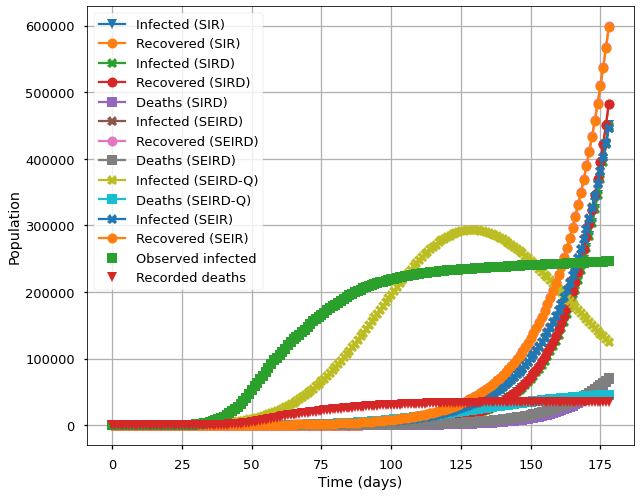

In [44]:
plt.figure(figsize=(9,7))

if has_to_run_sir:
    plt.plot(t_computed_sir, I_sir * target_population, label='Infected (SIR)', marker='v', linestyle="-", markersize=10)
    plt.plot(t_computed_sir, R_sir * target_population, label='Recovered (SIR)', marker='o', linestyle="-", markersize=10)
    
if has_to_run_sird:
    plt.plot(t_computed_sird, I_sird * target_population, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, R_sird * target_population, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, D_sird * target_population, label='Deaths (SIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seirdq:
    plt.plot(t_computed_seirdq, I_seirdq * target_population, label='Infected (SEIRD-Q)', marker='X', linestyle="-", markersize=10)
#     plt.plot(t_computed_seirdq, R_seirdq * target_population, label='Recovered (SEIRD-Q)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seirdq, D_seirdq * target_population, label='Deaths (SEIRD-Q)', marker='s', linestyle="-", markersize=10)

if has_to_run_seir:
    plt.plot(t_computed_seir, I_seir * target_population, label='Infected (SEIR)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seir, R_seir * target_population, label='Recovered (SEIR)', marker='o', linestyle="-", markersize=10)
    
plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()
plt.savefig("all_deterministic_calibration.png")
plt.show()

In [45]:
methods_list = list()
deaths_list = list()
if has_to_run_sird:
    methods_list.append("SIRD")
    deaths_list.append(int(D_sird.max() * target_population))
    print(f"Death estimate for today (SIRD):\t{int(D_sird.max() * target_population)}")
    
if has_to_run_seird:
    methods_list.append("SEIRD")
    deaths_list.append(int(D_seird.max() * target_population))
    print(f"Death estimate for today (SEIRD):\t{int(D_seird.max() * target_population)}")
    
if has_to_run_seirdq:
    methods_list.append("SEIRD-Q")
    deaths_list.append(int(D_seirdq.max() * target_population))
    print(f"Death estimate for today (SEIRD-Q):\t{int(D_seirdq.max() * target_population)}")

methods_list.append("Recorded")
deaths_list.append(int(dead_individuals[-1] * target_population))

death_estimates_dict = {"Method": methods_list, "Deaths estimate": deaths_list}
df_deaths_estimates = pd.DataFrame(death_estimates_dict)
print(f"Recorded deaths until today:\t{int(dead_individuals[-1] * target_population)}")

Death estimate for today (SIRD):	69932
Death estimate for today (SEIRD):	70598
Death estimate for today (SEIRD-Q):	46041
Recorded deaths until today:	35112


In [46]:
print(df_deaths_estimates.to_latex(index=False))

\begin{tabular}{lr}
\toprule
   Method &  Deaths estimate \\
\midrule
     SIRD &            69932 \\
    SEIRD &            70598 \\
  SEIRD-Q &            46041 \\
 Recorded &            35112 \\
\bottomrule
\end{tabular}



In [47]:
t0 = float(data_time.min())
number_of_days_after_last_record = 90
tf = data_time.max() + number_of_days_after_last_record
time_range = np.linspace(0., tf, int(tf))

if has_to_run_sir:
    solution_ODE_predict_sir = sir_ode_solver(y0_sir, (t0, tf), time_range, beta_fitted_sir, zeta_fitted)  # SIR
    t_computed_predict_sir, y_computed_predict_sir = solution_ODE_predict_sir.t, solution_ODE_predict_sir.y
    S_predict_sir, I_predict_sir, R_predict_sir = y_computed_predict_sir

if has_to_run_sird:
    solution_ODE_predict_sird = sird_ode_solver(y0_sird, (t0, tf), time_range, beta_fitted_sird, delta_fitted_sird, zeta_fitted)  # SIR
    t_computed_predict_sird, y_computed_predict_sird = solution_ODE_predict_sird.t, solution_ODE_predict_sird.y
    S_predict_sird, I_predict_sird, R_predict_sird, D_predict_sird = y_computed_predict_sird

if has_to_run_seird:
    solution_ODE_predict_seird = seird_ode_solver(y0_seird, (t0, tf), time_range, beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird, alpha_fitted, zeta_fitted)  # SEIRD
    t_computed_predict_seird, y_computed_predict_seird = solution_ODE_predict_seird.t, solution_ODE_predict_seird.y
    S_predict_seird, E_predict_seird, I_predict_seird, R_predict_seird, D_predict_seird = y_computed_predict_seird
    
if has_to_run_seirdq:
    solution_ODE_predict_seirdq = seirdq_ode_solver(y0_seird, (t0, tf), time_range, beta_fitted_seirdq, gamma_fitted_seirdq, delta_fitted_seirdq, omega_fitted_seirdq, alpha_fitted, zeta_fitted)  # SEIRD
    t_computed_predict_seirdq, y_computed_predict_seirdq = solution_ODE_predict_seirdq.t, solution_ODE_predict_seirdq.y
    S_predict_seirdq, E_predict_seirdq, I_predict_seirdq, R_predict_seirdq, D_predict_seirdq = y_computed_predict_seirdq

if has_to_run_seir:
    solution_ODE_predict_seir = seir_ode_solver(y0_seir, (t0, tf), time_range, beta_fitted_seir, gamma_fitted_seir, alpha_fitted, zeta_fitted)  # SEIR
    t_computed_predict_seir, y_computed_predict_seir = solution_ODE_predict_seir.t, solution_ODE_predict_seir.y
    S_predict_seir, E_predict_seir, I_predict_seir, R_predict_seir = y_computed_predict_seir

In [48]:
has_to_plot_infection_peak = True

if has_to_run_sir:
    crisis_day_sir = np.argmax(I_predict_sir)
    
if has_to_run_sird:
    crisis_day_sird = np.argmax(I_predict_sird)

if has_to_run_seir:
    crisis_day_seir = np.argmax(I_predict_seir)
    
if has_to_run_seird:
    crisis_day_seird = np.argmax(I_predict_seird)
    
if has_to_run_seirdq:
    crisis_day_seirdq = np.argmax(I_predict_seirdq)

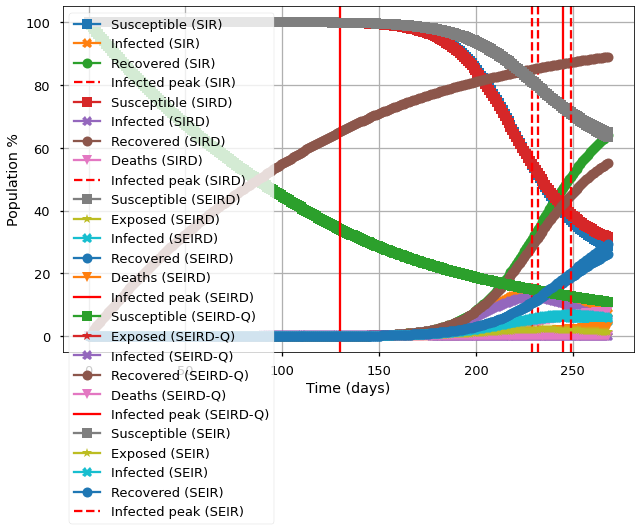

In [49]:
plt.figure(figsize=(9,7))

if has_to_run_sir:
    plt.plot(t_computed_predict_sir, 100 * S_predict_sir, label='Susceptible (SIR)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sir, 100 * I_predict_sir, label='Infected (SIR)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sir, 100 * R_predict_sir, label='Recovered (SIR)', marker='o', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_sir + 1, color="red", linestyle="--", label="Infected peak (SIR)")
    
if has_to_run_sird:
    plt.plot(t_computed_predict_sird, 100 * S_predict_sird, label='Susceptible (SIRD)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * I_predict_sird, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * R_predict_sird, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * D_predict_sird, label='Deaths (SIRD)', marker='v', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_sird + 1, color="red", linestyle="--", label="Infected peak (SIRD)")

if has_to_run_seird:
    plt.plot(t_computed_predict_seird, 100 * S_predict_seird, label='Susceptible (SEIRD)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * E_predict_seird, label='Exposed (SEIRD)', marker='*', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * I_predict_seird, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * R_predict_seird, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * D_predict_seird, label='Deaths (SEIRD)', marker='v', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_seird + 1, color="red", label="Infected peak (SEIRD)")
    
if has_to_run_seirdq:
    plt.plot(t_computed_predict_seirdq, 100 * S_predict_seirdq, label='Susceptible (SEIRD-Q)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seirdq, 100 * E_predict_seirdq, label='Exposed (SEIRD-Q)', marker='*', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seirdq, 100 * I_predict_seirdq, label='Infected (SEIRD-Q)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seirdq, 100 * R_predict_seirdq, label='Recovered (SEIRD-Q)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seirdq, 100 * D_predict_seirdq, label='Deaths (SEIRD-Q)', marker='v', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_seirdq + 1, color="red", label="Infected peak (SEIRD-Q)")

if has_to_run_seir:
    plt.plot(t_computed_predict_seir, 100 * S_predict_seir, label='Susceptible (SEIR)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seir, 100 * E_predict_seir, label='Exposed (SEIR)', marker='*', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seir, 100 * I_predict_seir, label='Infected (SEIR)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seir, 100 * R_predict_seir, label='Recovered (SEIR)', marker='o', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_seir + 1, color="red", linestyle="--", label="Infected peak (SEIR)")

plt.xlabel('Time (days)')
plt.ylabel('Population %')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("seir_deterministic_predictions.png")
plt.show()

In [50]:
if has_to_run_sir:
    print(f"Max number of infected individuals (SIR model):\t {int(np.max(I_predict_sir) * target_population)}")
    print(f"Population percentage of max number of infected individuals (SIR model):\t {np.max(I_predict_sir) * 100:.2f}%")
    print(f"Day estimate for max number of infected individuals (SIR model):\t {crisis_day_sir + 1}")
    print("")

if has_to_run_sird:
    print(f"Max number of infected individuals (SIRD model):\t {int(np.max(I_predict_sird) * target_population)}")
    print(f"Population percentage of max number of infected individuals (SIRD model):\t {np.max(I_predict_sird) * 100:.2f}%")
    print(f"Day estimate for max number of infected individuals (SIRD model):\t {crisis_day_sird + 1}")
    print(f"Percentage of number of death estimate (SIRD model):\t {100 * D_predict_sird[-1]:.3f}%")
    print(f"Number of death estimate (SIRD model):\t {target_population * D_predict_sird[-1]:.3f}")
    print("")

if has_to_run_seir:
    print(f"Max number of infected individuals (SEIR model):\t {int(np.max(I_predict_seir) * target_population)}")
    print(f"Population percentage of max number of infected individuals (SEIR model):\t {np.max(I_predict_seir) * 100:.2f}%")
    print(f"Day estimate for max number of infected individuals (SEIR model):\t {crisis_day_seir + 1}")
    print("")
    
if has_to_run_seird:
    print(f"Max number of infected individuals (SEIRD model):\t {int(np.max(I_predict_seird) * target_population)}")
    print(f"Population percentage of max number of infected individuals (SEIRD model):\t {np.max(I_predict_seird) * 100:.2f}%")
    print(f"Day estimate for max number of infected individuals (SEIRD model):\t {crisis_day_seird + 1}")
    print(f"Percentage of number of death estimate (SEIRD model):\t {100 * D_predict_seird[-1]:.3f}%")
    print(f"Number of death estimate (SEIRD model):\t {target_population * D_predict_seird[-1]:.3f}")
    print("")
    
if has_to_run_seirdq:
    print(f"Max number of infected individuals (SEIRD-Q model):\t {int(np.max(I_predict_seirdq) * target_population)}")
    print(f"Population percentage of max number of infected individuals (SEIRD-Q model):\t {np.max(I_predict_seirdq) * 100:.2f}%")
    print(f"Day estimate for max number of infected individuals (SEIRD-Q model):\t {crisis_day_seirdq + 1}")
    print(f"Percentage of number of death estimate (SEIRD-Q model):\t {100 * D_predict_seirdq[-1]:.3f}%")
    print(f"Number of death estimate (SEIRD-Q model):\t {target_population * D_predict_seirdq[-1]:.3f}")
    print("")

Max number of infected individuals (SIR model):	 8425829
Population percentage of max number of infected individuals (SIR model):	 14.49%
Day estimate for max number of infected individuals (SIR model):	 232

Max number of infected individuals (SIRD model):	 7181225
Population percentage of max number of infected individuals (SIRD model):	 12.35%
Day estimate for max number of infected individuals (SIRD model):	 229
Percentage of number of death estimate (SIRD model):	 7.979%
Number of death estimate (SIRD model):	 4638281.403

Max number of infected individuals (SEIR model):	 4038646
Population percentage of max number of infected individuals (SEIR model):	 6.95%
Day estimate for max number of infected individuals (SEIR model):	 249

Max number of infected individuals (SEIRD model):	 3475284
Population percentage of max number of infected individuals (SEIRD model):	 5.98%
Day estimate for max number of infected individuals (SEIRD model):	 245
Percentage of number of death estimate (SE